In [15]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,ChebConv, SAGEConv, GATConv, GINConv
from torch.nn import Linear

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0] 

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, activationGNN, activationOut):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fullyConnected = Linear(hidden_channels, dataset.num_classes)
        self.activationGNN = activationGNN
        self.activationOut = activationOut

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [10]:
class Sage(torch.nn.Module):
    def __init__(self, hidden_channels, activationGNN, activationOut):
        super(Sage, self).__init__()
        torch.manual_seed(42)
        
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fullyConnected = Linear(hidden_channels, dataset.num_classes)
        self.activationGNN = activationGNN
        self.activationOut = activationOut

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fully Connected Output layer 
        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [17]:
class Cheb(torch.nn.Module):
    def __init__(self, hidden_channels, activationGNN, activationOut):
        super(Cheb, self).__init__()
        torch.manual_seed(42)
        
        self.conv1 = ChebConv(dataset.num_features, hidden_channels, K=2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=2)
        self.fullyConnected = Linear(hidden_channels, dataset.num_classes)
        self.activationGNN = activationGNN
        self.activationOut = activationOut

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [12]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, activationGNN, activationOut):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.fullyConnected = Linear(hidden_channels, dataset.num_classes)
        self.activationGNN = activationGNN
        self.activationOut = activationOut

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)

        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [18]:
gcn = GCN(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)
cheb = Cheb(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)
sage = Sage(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)
gat = GAT(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)

optimizer1 = torch.optim.Adam(gcn.parameters())
optimizer2 = torch.optim.Adam(cheb.parameters())
optimizer3 = torch.optim.Adam(sage.parameters())
optimizer4 = torch.optim.Adam(gat.parameters())

In [4]:
model = GCN(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

In [5]:
torch.cuda.is_available()

False

In [21]:
# Wskazówka z zadania "Podczas treningu modeli klasyfikujących zazwyczaj rozważa się funkcję entropii krzyżowej jako funkcję straty.""
criterion = torch.nn.CrossEntropyLoss()

<font size='5'>Poniższa część jest uniwersalna dla wszystkich modeli ponieważ są to tylko funkcje trenujące i testujące </font>

In [113]:
def train():
      model.train()
      optimizer.zero_grad() 
      out = model(data.x, data.edge_index)  
      # Używamy tylko nodów z labelkami do obliczenia funkcji straty
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

In [121]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc, pred

<font size='5'>Sprawdzenie różnych rodzajow warstw </font>

In [28]:
def trainTMP(model, optimizer):
      model.train()
      optimizer.zero_grad() 
      out = model(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

In [26]:
def testTMP(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

In [33]:
# Funckja do trenowania modelu przez zadaną liczbę epok
def final_trainTMP(epochs, model, optimizer):
    for epoch in range(0, epochs):
        loss = trainTMP(model, optimizer)
    return loss

In [34]:
loss1 = final_trainTMP(1000, gcn, optimizer1)
print(testTMP(gcn))

0.769


In [36]:
loss2 = final_trainTMP(1000, cheb, optimizer2)
print(testTMP(cheb))

0.741


In [37]:
loss3 = final_trainTMP(1000, sage, optimizer3)
print(testTMP(sage))

0.726


In [38]:
loss4 = final_trainTMP(1000, gat, optimizer4)
print(testTMP(gat))

0.7


<font size='5'>Sprawdzenie flattena </font>

In [55]:
class GCNFlatten(torch.nn.Module):
    def __init__(self, hidden_channels, activationGNN, activationOut):
        super(GCNFlatten, self).__init__()
        torch.manual_seed(42)
        
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fullyConnected = Linear(hidden_channels, dataset.num_classes)
        self.activationGNN = activationGNN
        self.activationOut = activationOut

    def forward(self, x, edge_index):
        print("przed 1 warstwa: " + str(x.shape))
        x = self.conv1(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)
        print("po 1 warstwie: " + str(x.shape))

        x = self.conv2(x, edge_index)
        x = self.activationGNN(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        print("przed flatten: " + str(x.shape))
        
        x = x.flatten()
        
        print("po flatten: " + str(x.shape))
 
        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [56]:
# EDIT: nie ma sensu poolowac ani stosować flattena bo to i tak jest przekazywany sam wektor jednowymiarowy, nie graf jako struktura

gcnFlatten = GCNFlatten(hidden_channels=16, activationGNN=torch.relu, activationOut=torch.softmax)
optimizer = torch.optim.Adam(gcnFlatten.parameters())
loss1 = final_trainTMP(1000, gcnFlatten, optimizer)
print(testTMP(gcnFlatten))

przed 1 warstwa: torch.Size([2708, 1433])
po 1 warstwie: torch.Size([2708, 16])
przed flatten: torch.Size([2708, 16])
po flatten: torch.Size([43328])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x43328 and 16x7)

In [40]:
losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

NameError: name 'model' is not defined

C:\Users\MICHU13\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

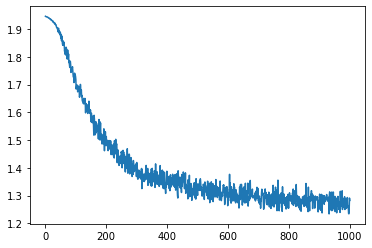

In [11]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

<font size='5'>Część na testowanie hiperparametrów, najlepszą kombinację wybierzemy po mierze Accuracy </font>

In [41]:
# Tablica do przechowywania wartości accuracy z poszczególnych modeli
accuracies = []
# Tablica do przechowywania hiperparametrów danego modelu
params = []

In [146]:
# Funckja do trenowania modelu przez zadaną liczbę epok
def final_train(epochs):
    losses = []
    for epoch in range(0, epochs):
        loss = train()
        losses.append(loss)
    return losses

In [43]:
# Funkcja stworzona dlatego, że optimizer trzeba stworzyć po modelu(przyjmiuje model.parameters() jako parametr) więc nie możemy zadeklarować tablicy optimizerów, dlatego stworzymy tablice, 
# która zawiera tylko nazwy, a potem po stworzeniu modelu użyjemy tej funkcji żeby stworzyć odpowiedni optimizer
def assign_optimizer(model, optimizer_name):
    if optimizer_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=0.01)
    elif optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adagrad':
        return torch.optim.Adagrad(model.parameters(), lr=0.01)
    else:
        return -1

In [44]:
# Definiujemy tablice hiperparametrów, które będziemy testować
hidden_channels_tab = [16, 32, 64]
activationGNN_tab = [torch.relu, torch.tanh, F.leaky_relu]
activationOut_tab = [torch.softmax, torch.sigmoid]
optimizers_tab = ['SGD', 'Adam', 'Adagrad']

In [57]:
for h_c in hidden_channels_tab:
    for aGNN in activationGNN_tab:
        for aOut in activationOut_tab:
            for opt in optimizers_tab:
                model = GCN(hidden_channels=h_c, activationGNN=aGNN, activationOut=aOut)
                optimizer = assign_optimizer(model, opt)
                loss = final_train(1000)
                accuracies.append(test())
                params.append(['hidden_chanels: ' + str(h_c), 'activationGNN: ' + str(aGNN), 'activationOut: ' + str(aOut), 'optimizer: ' + opt,])
                print(accuracies[-1])

0.129
0.712
0.779
0.144
0.7
0.771
0.245
0.735
0.741
0.272
0.745
0.744
0.129
0.75
0.782
0.146
0.684
0.772
0.149
0.774
0.772
0.149
0.769
0.771
0.159
0.759
0.767
0.2
0.772
0.764
0.149
0.759
0.769
0.149
0.776
0.77
0.121
0.759
0.784
0.14
0.78
0.785
0.221
0.771
0.776
0.296
0.776
0.773
0.12
0.792
0.788
0.141
0.773
0.786


In [58]:
print(accuracies)
for elem in params:
    print(elem)

[0.129, 0.129, 0.129, 0.712, 0.779, 0.144, 0.7, 0.771, 0.245, 0.735, 0.741, 0.272, 0.745, 0.744, 0.129, 0.75, 0.782, 0.146, 0.684, 0.772, 0.149, 0.774, 0.772, 0.149, 0.769, 0.771, 0.159, 0.759, 0.767, 0.2, 0.772, 0.764, 0.149, 0.759, 0.769, 0.149, 0.776, 0.77, 0.121, 0.759, 0.784, 0.14, 0.78, 0.785, 0.221, 0.771, 0.776, 0.296, 0.776, 0.773, 0.12, 0.792, 0.788, 0.141, 0.773, 0.786]
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: SGD']
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: SGD']
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: SGD']
['hidden_chanels

In [61]:
print(accuracies.index(max(accuracies)))

51


In [63]:
print(accuracies[51])

0.792


In [62]:
print(params[51])

['hidden_chanels: 64', 'activationGNN: <function leaky_relu at 0x000001E7E4968C10>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: Adam']


<font size='5'>Zatem badamy najlepszy model o parametrach: hidden_channels=64, activationGNN=leaky_realu, activationOut(linear)=softmax, optimizer=Adam </font>

In [151]:
model = GCN(hidden_channels=64, activationGNN=F.leaky_relu, activationOut=torch.softmax)
optimizer = assign_optimizer(model, 'Adam')
losses = final_train(100)

In [ ]:
tmp = [float(loss.detach().numpy()) for loss in losses]
for elem in tmp:
    print(elem)

C:\Users\MICHU13\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


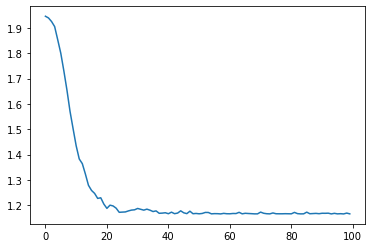

In [152]:
import seaborn as sns
losses_float = [float(loss.detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)

C:\Users\MICHU13\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


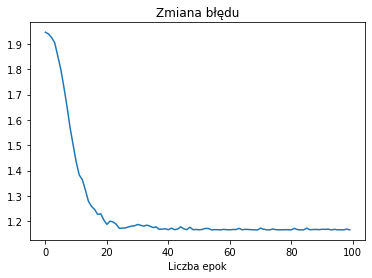

In [160]:
import matplotlib.pyplot as plt
sns.lineplot(loss_indices, losses_float)
plt.title('Zmiana błędu')
plt.xlabel('Liczba epok')
plt.show()

In [123]:
accuracy, predictions = test()
print(test())

0.792


In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [68]:
y = dataset.data.y.numpy()
test_mask = data['test_mask']
test_indices = torch.arange(len(y))[test_mask]

C:\Users\MICHU13\anaconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [124]:
# model.eval()
# out = model(data.x, data.edge_index)
# pred = out.argmax(dim=1)
pred = predictions[data.test_mask]
correct = data.y[data.test_mask]
pred = pred.numpy()
correct = correct.numpy()

In [125]:
print([pred])

[array([1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 6, 4, 4, 4,
       4, 4, 1, 3, 0, 1, 1, 6, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 6, 6, 3, 0, 0,
       0, 0, 5, 0, 0, 4, 3, 0, 0, 6, 0, 6, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 0, 5, 5, 5, 5,
       5, 5, 2, 2, 2, 4, 4, 4, 4, 3, 3, 2, 5, 5, 5, 5, 6, 5, 5, 5, 5, 4,
       4, 3, 4, 3, 1, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 6, 0,
       3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       6, 0, 0, 6, 6, 0, 5, 5, 5, 0, 5, 4, 4, 4, 3, 3, 3, 3, 3, 1, 2, 3,
       3, 2, 3, 3, 1, 3, 2, 4, 4, 4, 3, 3, 3, 3, 3

In [126]:
print("Accuracy: " + str(accuracy_score(correct, pred)))
print("Precision(weighted): " + str(precision_score(correct, pred, average='weighted')))
print("Precision(macro): " + str(precision_score(correct, pred, average='macro')))
print("Recall(weighted): " + str(recall_score(correct, pred, average='weighted')))
print("Recall(macro): " + str(recall_score(correct, pred, average='macro')))
print("F1(weighted): " + str(f1_score(correct, pred, average='weighted')))
print("F1(macro): " + str(f1_score(correct, pred, average='macro')))


Accuracy: 0.792
Precision(weighted): 0.797565596394222
Precision(macro): 0.7762636718023957
Recall(weighted): 0.792
Recall(macro): 0.8055667123082086
F1(weighted): 0.7922178836736319
F1(macro): 0.7885435013083982


In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

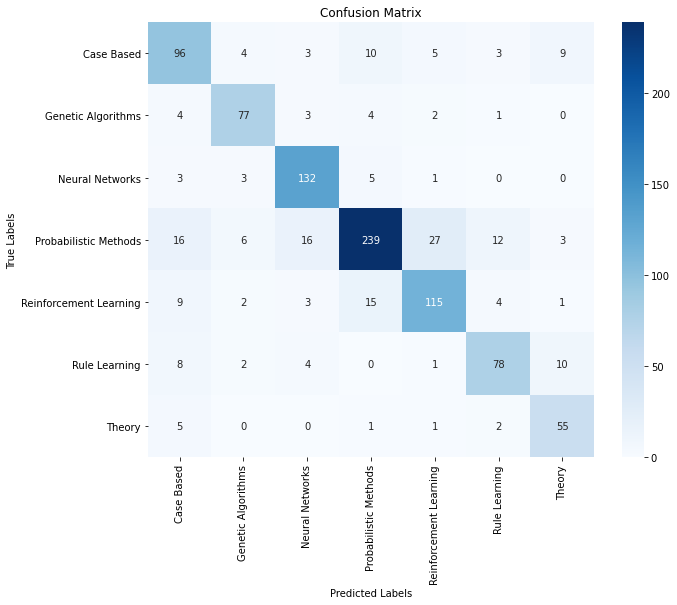

In [130]:
cm = confusion_matrix(correct, pred)
classes = ['Case Based', 'Genetic Algorithms', 'Neural Networks', 'Probabilistic Methods', 'Reinforcement Learning', 'Rule Learning', 'Theory']
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()